In [1]:
%matplotlib inline
# 以下两行是为了在模块被修改之后重新载入
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
from typing import Union, Optional, Sequence, Mapping
import time
import logging
import numpy as np
import pandas as pd
import h5py
import scanpy as sc


In [3]:
CAME_PATH = Path('../../CAME')
sys.path.append(str(CAME_PATH))

from came import pp, pl
import came

In [4]:
ROOT = Path('../')
RESDIR = ROOT / 'results'

# =======================
resdir = RESDIR / 'came'
figdir = resdir / 'figs'

os.makedirs(figdir, exist_ok=True)

In [5]:
# human to dog
obs_hd = pd.read_csv(resdir / 'obs-human2dog.csv', index_col=0)
obs_dh = pd.read_csv(resdir / 'obs-dog2human.csv', index_col=0)

obs_hd

,original_name,dataset,REF,celltype,predicted,max_probs,is_right,InN,Progenitor,ExN,OPC,Endothelial,Erythroid,Microglia,Astrocyte,Cajal-Retzius,Oligo,Astrocyte-L,UMAP1,UMAP2
0,AAACCTGAGTATCGAA-1,human,InN,InN,InN,0.817159,True,0.817159,0.014696,0.021597,0.020316,0.019477,0.019798,0.014900,0.019513,0.028598,0.010122,0.013823,-0.769439,10.980394
1,AAACCTGCAGTAAGCG-1,human,Progenitor,Progenitor,Progenitor,0.779920,True,0.030220,0.779920,0.011888,0.048156,0.017630,0.023282,0.015900,0.009227,0.020554,0.022662,0.020560,8.048991,10.198677
2,AAACCTGTCGCCGTGA-1,human,Progenitor,Progenitor,Progenitor,0.776788,True,0.022723,0.776788,0.014555,0.018825,0.025915,0.013146,0.014756,0.049885,0.029023,0.010932,0.023452,8.007531,10.196220
3,AAACGGGAGCCTCGTG-1,human,ExN,ExN,ExN,0.819939,True,0.022025,0.019622,0.819939,0.024780,0.020820,0.014213,0.015724,0.013509,0.020828,0.009856,0.018684,-3.273813,-1.268798
4,AAACGGGAGTTCGATC-1,human,OPC,OPC,OPC,0.793756,True,0.024875,0.009862,0.023268,0.793756,0.017442,0.010919,0.017124,0.026048,0.022393,0.031527,0.022785,4.504251,10.329759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38678,GACTAGTAGACTAGTAGCGAGTAA,dog,unknown,GABAergic neurons,Astrocyte-L,0.293058,False,0.268820,0.006694,0.086056,0.061982,0.031860,0.031983,0.039734,0.014337,0.090060,0.075416,0.293058,-0.943446,3.947439
38679,TCTTCACAAGAGTCAATGAAGAGA,dog,unknown,Astrocytes,Progenitor,0.369562,False,0.013873,0.369562,0.053298,0.010413,0.031490,0.021563,0.024652,0.295965,0.024432,0.058294,0.096459,7.284281,8.464176
38680,GCCAAGACCCTAATCCGCCACATA,dog,unknown,Glutamatergic neurons,ExN,0.709147,False,0.028171,0.011652,0.709147,0.034112,0.026238,0.022502,0.015806,0.013774,0.042701,0.014097,0.081801,-0.227510,-0.649347
38681,GCCAAGACAAGGTACATGGTGGTA,dog,Microglia,Microglia,Microglia,0.301098,True,0.018815,0.043410,0.174699,0.008209,0.019032,0.019749,0.301098,0.182513,0.038283,0.064209,0.129983,7.116640,5.789177


In [8]:
sorted(obs_dh['REF'].unique())

['Astrocytes',
 'Cajal-Retzius',
 'Endothelial cells',
 'GABAergic neurons',
 'Glutamatergic neurons',
 'Microglia',
 'Myelinating oligodendrocyte',
 'Myelinating oligodendrocytes',
 'Non-neurons',
 'Oligodendrocyte precursor cells',
 'Unknown',
 'unknown']

In [62]:

orders_dog = [
 'Glutamatergic neurons',
 'GABAergic neurons',
 'Cajal-Retzius',
 'Unknown',
 'Oligodendrocyte precursor cells',
 'Myelinating oligodendrocytes',
 'Myelinating oligodendrocyte',
 'Astrocytes',
 'Non-neurons',
 'Microglia',
 'Endothelial cells',

]
orders_human = [
 'ExN',
 'InN',
 'Cajal-Retzius',
 'OPC',
 'Oligo',
 'Progenitor',
 'Astrocyte',
 'Astrocyte-L',
 'Microglia',
 'Endothelial',
 'Erythroid',
]

matching_dh = {
 'Astrocytes': 'Astrocyte',
 'Cajal-Retzius': 'Cajal-Retzius',
 'Endothelial cells': 'Endothelial',
 'GABAergic neurons': 'InN',
 'Glutamatergic neurons': 'ExN',
 'Microglia': 'Microglia',
 'Myelinating oligodendrocyte': 'Oligo',
 'Myelinating oligodendrocytes': 'Oligo',
 'Non-neurons': 'Astrocyte-L',
 'Oligodendrocyte precursor cells': 'OPC',
 'Unknown': 'Oligo',
}

matching_hd = {
 'Astrocyte': 'Astrocytes',
 'Astrocyte-L': 'Non-neurons',
 'Cajal-Retzius': 'Cajal-Retzius',
 'Endothelial': 'Endothelial cells',
 'Erythroid': 'Endothelial cells',
 'ExN': 'Glutamatergic neurons',
 'InN': 'GABAergic neurons',
 'Microglia': 'Microglia',
 'OPC': 'Oligodendrocyte precursor cells',
 'Oligo': 'Unknown',
 'Progenitor': 'Astrocytes',
}



figure has been saved into:
	../results/came/figs/heatmap-human2dog.pdf


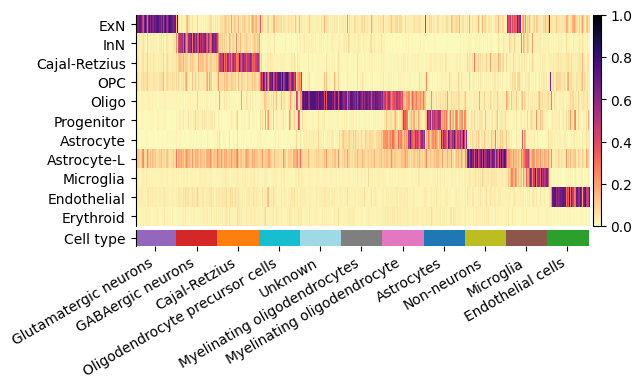

In [64]:
obs = obs_hd
name_que = 'dog'

classes = sorted(obs['REF'].unique())
classes = [c for c in classes if c != 'unknown']
df_probs = obs[classes]
is_que = obs['dataset'] == name_que

type_order_pred = orders_human

cl_ord = dict(zip(type_order_pred, range(len(classes))))
type_order_true = sorted(orders_dog, key=lambda x: cl_ord[matching_dh[x]])
# type_order_true = orders_dog

# type_order_true, type_order_pred
gs = pl.wrapper_heatmap_scores(
    df_probs[is_que], obs[is_que], filter_null=False,
    type_order_true=type_order_true,
    type_order_pred=type_order_pred,
    fp=figdir / 'heatmap-human2dog.pdf'
)
gs.figure

figure has been saved into:
	../results/came/figs/heatmap-dog2human.pdf


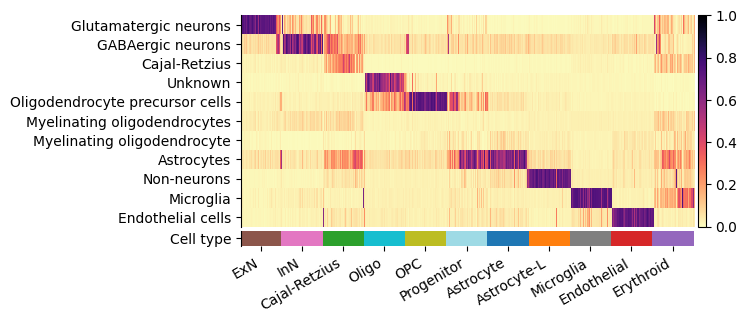

In [59]:
obs = obs_dh
name_que = 'human'

classes = sorted(obs['REF'].unique())
classes = [c for c in classes if c != 'unknown']
df_probs = obs[classes]
is_que = obs['dataset'] == name_que

type_order_pred = orders_dog

cl_ord = dict(zip(type_order_pred, range(len(classes))))
type_order_true = sorted(orders_human, key=lambda x: cl_ord[matching_hd[x]])


gs = pl.wrapper_heatmap_scores(
    df_probs[is_que], obs[is_que], filter_null=False,
    type_order_true=type_order_true,
    type_order_pred=type_order_pred,  # n_subsample=None,
    fp=figdir / 'heatmap-dog2human.pdf'
)
gs.figure

## Compare DEGs

In [66]:
dir_gmap = ROOT / 'resources'

df_gmap = pd.read_csv(dir_gmap / 'homo-dog2human.csv')
# df_gmap = pd.read_csv(dir_gmap / 'homo-dog2mouse.csv')
print(df_gmap.isna().any())
df_gmap = df_gmap.iloc[:, [3, 1]]
df_gmap.head()

Gene stable ID          False
Gene name               False
Human gene stable ID    False
Human gene name         False
dtype: bool


,Human gene name,Gene name
0,PHLPP1,PHLPP1
1,RMND1,RMND1
2,ENPP1,ENPP1
3,CLVS2,CLVS2
4,ARMT1,ARMT1


In [81]:
dir_deg = RESDIR / 'DEG'

df_deg_h = pd.read_csv(dir_deg / 'human/DEGtable_cluster(MAST).csv')
df_deg_d = pd.read_csv(dir_deg / 'dog/DEGtable_cluster(MAST).csv')


In [120]:
cl2major_d = {
    '18 Myelinating oligodendrocytes': '18 Myelinating oligodendrocyte', 
    '19 Non-neuron': '19 Non-neurons', 
    '22 Non-neuron': '22 Non-neurons', 
}
df_deg_d['cluster1'] = df_deg_d['cluster'].apply(lambda x: cl2major_d.get(x, x))
df_deg_d['major_type'] = df_deg_d['cluster1'].apply(lambda x: ' '.join(x.split()[1:]))
df_deg_d.head()
df_deg_d['major_type'].unique()
# df_deg_d['cluster'].unique()

array(['Glutamatergic neurons', 'GABAergic neurons', 'Cajal-Retzius',
       'Astrocytes', 'Microglia', 'Oligodendrocyte precursor cells',
       'Unknown', 'Myelinating oligodendrocytes',
       'Myelinating oligodendrocyte', 'Non-neurons', 'Endothelial cells'],
      dtype=object)

In [113]:
df_deg_h['cluster'].unique()

cl2major_h = {
#     'Astrocyte', 
#     'Astrocyte-L', 
#     'Cajal-Retzius', 
    'Endothelial_CLDN5': 'Endothelial',
#     'Endothelial', 
#     'Erythroid', 
    'ExN-DG': 'ExN', 
    'ExN-nonDG': 'ExN', 
    'InN-CGE': 'InN',
    'InN-MGE': 'InN', 
    'InN-VIP': 'InN', 
    'UNK-InN': 'InN',
#     'Microglia', 
#     'Oligo', 
#     'OPC',
#     'Progenitor', 
    'UNK_SLC18A2': 'Progenitor',
}

In [85]:
df_deg_h['major_type'] = df_deg_h['cluster'].apply(lambda x: cl2major_h.get(x, x))
df_deg_h.head()

,Unnamed: 0,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,major_type
0,CST3,0.0,3.509397,0.977,0.427,0.0,Astrocyte,CST3,Astrocyte
1,VIM,0.0,3.231898,0.959,0.163,0.0,Astrocyte,VIM,Astrocyte
2,CLU,0.0,3.106912,0.977,0.162,0.0,Astrocyte,CLU,Astrocyte
3,PTN,0.0,3.044531,0.937,0.337,0.0,Astrocyte,PTN,Astrocyte
4,TTYH1,0.0,2.353212,0.950,0.141,0.0,Astrocyte,TTYH1,Astrocyte


In [139]:
df_deg_h['p_val_adj'].describe()

count     7.021000e+03
mean      5.150863e-02
std       2.157702e-01
min       0.000000e+00
25%      4.309168e-231
50%       2.309769e-82
75%       2.520671e-28
max       1.000000e+00
Name: p_val_adj, dtype: float64

In [133]:
from came import ana

key_group = 'cluster'
key_group = 'major_type'


res = ana.compare_degs_seurat(
    df_deg_h, df_deg_d, df_gmap, cut_padj=0.001, 
    product=True, key_group=key_group,)

In [134]:
res.keys()

dict_keys(['common1v1', 'common1', 'common2', 'private1', 'private2'])

In [144]:
came.save_json_dict(res, dir_deg / 'deg_comparison.json')
pd.DataFrame(res['common1v1']).to_excel(dir_deg / 'deg_common1v1.xlsx')

In [135]:
n_common1v1 = pd.DataFrame(res['common1v1']).applymap(len)
n_common1 = pd.DataFrame(res['common1']).applymap(len)
n_common2 = pd.DataFrame(res['common2']).applymap(len)
n_private1 = pd.DataFrame(res['private1']).applymap(len)
n_private2 = pd.DataFrame(res['private2']).applymap(len)

n_common1v1

,Astrocyte,Astrocyte-L,Cajal-Retzius,Endothelial,Erythroid,ExN,InN,Microglia,OPC,Oligo,Progenitor
Astrocytes,39,24,8,26,0,7,7,7,22,23,20
Cajal-Retzius,2,2,13,11,0,10,10,2,3,5,0
Endothelial cells,9,2,5,103,0,2,5,15,8,3,5
GABAergic neurons,9,9,21,15,0,13,50,5,17,15,3
Glutamatergic neurons,15,16,46,27,0,48,58,17,33,37,6
Microglia,5,3,2,19,0,2,4,46,5,9,3
Myelinating oligodendrocyte,26,11,3,12,0,4,3,4,18,18,13
Myelinating oligodendrocytes,10,8,5,20,0,9,14,8,18,36,7
Non-neurons,17,91,6,23,0,7,11,10,13,13,9
Oligodendrocyte precursor cells,7,2,3,8,0,4,13,2,44,27,8


In [136]:
n_private2

,Astrocyte,Astrocyte-L,Cajal-Retzius,Endothelial,Erythroid,ExN,InN,Microglia,OPC,Oligo,Progenitor
Astrocytes,141,159,174,155,183,174,175,176,159,159,162
Cajal-Retzius,113,113,102,104,115,105,105,113,112,110,115
Endothelial cells,178,186,184,79,189,187,184,173,180,184,183
GABAergic neurons,417,414,396,403,430,410,325,423,395,407,424
Glutamatergic neurons,1213,1203,1116,1184,1238,1114,1105,1204,1154,1167,1228
Microglia,143,145,146,129,148,145,144,102,143,139,145
Myelinating oligodendrocyte,85,100,108,99,111,107,108,107,93,93,98
Myelinating oligodendrocytes,196,200,202,186,208,199,193,199,188,170,200
Non-neurons,393,305,409,391,416,404,404,406,403,402,403
Oligodendrocyte precursor cells,115,120,119,114,122,118,109,120,77,95,114


figure has been saved into:
	../results/DEG/heatmap-nCommon1v1.pdf
figure has been saved into:
	../results/DEG/heatmap-nCommon1v1-annot.pdf


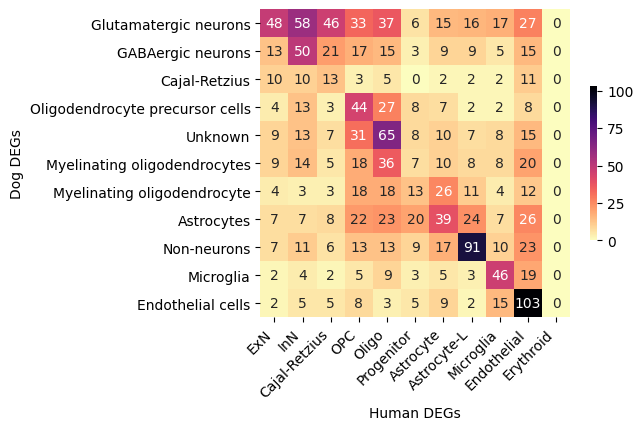

In [142]:
orders_dog_hmp = [
 'Glutamatergic neurons',
 'GABAergic neurons',
 'Cajal-Retzius',
 'Oligodendrocyte precursor cells',
 'Unknown',
 'Myelinating oligodendrocytes',
 'Myelinating oligodendrocyte',
 'Astrocytes',
 'Non-neurons',
 'Microglia',
 'Endothelial cells',

]
orders_human_hmp = [
 'ExN',
 'InN',
 'Cajal-Retzius',
 'OPC',
 'Oligo',
 'Progenitor',
 'Astrocyte',
 'Astrocyte-L',
 'Microglia',
 'Endothelial',
 'Erythroid',
]


pl.heatmap(n_common1v1.loc[orders_dog_hmp, orders_human_hmp], 
           figsize=(5, 4), 
           xlabel='Human DEGs', ylabel='Dog DEGs', 
           fp=dir_deg / 'heatmap-nCommon1v1.pdf'
          )
ax = pl.heatmap(n_common1v1.loc[orders_dog_hmp, orders_human_hmp], 
           figsize=(5, 4), 
           annot=n_common1v1.loc[orders_dog_hmp, orders_human_hmp], 
           fmt='d', 
           xlabel='Human DEGs', ylabel='Dog DEGs', 
           fp=dir_deg / 'heatmap-nCommon1v1-annot.pdf'
          )
ax.figure

## UMAP plots

In [149]:
dir_umap = RESDIR / 'harmony-crosssp'

xumap = pd.read_csv(dir_umap / 'UMAP-harmony.csv', index_col=0)
obs0 = pd.read_csv(dir_umap / 'metadata-merged.csv', index_col=0)
xumap
obs0

/Users/xingyan/.conda/envs/dgl/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,orig.ident,nCount_RNA,nFeature_RNA,batch,n_genes,n_counts,n_genes_disc,n_counts_disc,primer,leiden,leiden_anno,major_type,UMAP_1,UMAP_2,species,anno0,anno1
CCGACAACGACTAGTACGCTGATC,SeuratProject,11462,3612,A,4620.0,14747.0,2.0,2.0,polyT,7,7 Glutamatergic neurons,Glutamatergic neurons,4.059613,-6.722668,dog,NaN,NaN
AACGTGATAATCCGTCCGCATACA,SeuratProject,12846,3612,A,4621.0,16140.0,2.0,2.0,polyT,20,20 Glutamatergic neurons,Glutamatergic neurons,8.901380,-9.360164,dog,NaN,NaN
GACTAGTACCTCCTGAAGAGTCAA,SeuratProject,10191,3406,A,4380.0,13002.0,2.0,2.0,polyT,20,20 Glutamatergic neurons,Glutamatergic neurons,8.020183,-9.338976,dog,NaN,NaN
ATCATTCCAGTACAAGCCTCCTGA,SeuratProject,9265,3307,A,4217.0,11742.0,2.0,2.0,polyT,6,6 Glutamatergic neurons,Glutamatergic neurons,0.698022,-7.952873,dog,NaN,NaN
CAGCGTTATATCAGCACACTTCGA,SeuratProject,9489,3060,A,3860.0,11933.0,2.0,2.0,polyT,20,20 Glutamatergic neurons,Glutamatergic neurons,8.730353,-9.426841,dog,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCGAAGAG-8,SeuratProject,2735,1582,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,Progenitor,-7.236984,8.424458,human,Progenitor,Progenitor
TTTGTCAAGGGCACTA-8,SeuratProject,1653,899,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,Progenitor,-7.646222,9.499486,human,Progenitor,Progenitor
TTTGTCAGTAAGGATT-8,SeuratProject,485,408,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,ExN,7.065081,-3.155610,human,ExN-nonDG,ExN-nonDG
TTTGTCATCAACGCTA-8,SeuratProject,2086,1138,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,Progenitor,-7.555118,9.313449,human,Progenitor,Progenitor


In [172]:
from scipy import sparse


def fake_adt_with_umap(x_umap, obs=None, **kwds):
    
    n = x_umap.shape[0]
    x = sparse.csr_matrix((n, 100))
    adt = sc.AnnData(x, obs=obs, **kwds)
    adt.obsm['X_umap'] = x_umap.values

    return adt


xumap1 = xumap[obs0['species'] == 'dog']
xumap2 = xumap[obs0['species'] == 'human']
xumap2


adt = fake_adt_with_umap(xumap, obs=obs0)

adt1 = fake_adt_with_umap(xumap1, obs=obs0[obs0['species'] == 'dog'])
adt2 = fake_adt_with_umap(xumap2, obs=obs0[obs0['species'] == 'human'])


sc.set_figure_params(fontsize=13)


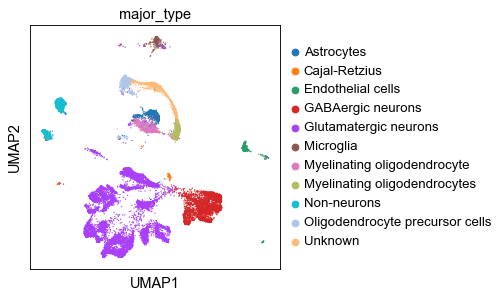

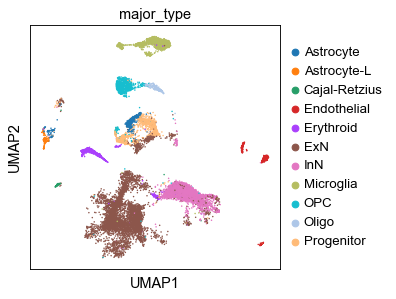

In [175]:
sc.pl.umap(adt1, color='major_type')
sc.pl.umap(adt2, color='major_type')

In [176]:
dict(zip(adt1.obs['major_type'].cat.categories, adt1.uns['major_type_colors'])),\
dict(zip(adt2.obs['major_type'].cat.categories, adt2.uns['major_type_colors']))

({'Astrocytes': '#1f77b4',
  'Cajal-Retzius': '#ff7f0e',
  'Endothelial cells': '#279e68',
  'GABAergic neurons': '#d62728',
  'Glutamatergic neurons': '#aa40fc',
  'Microglia': '#8c564b',
  'Myelinating oligodendrocyte': '#e377c2',
  'Myelinating oligodendrocytes': '#b5bd61',
  'Non-neurons': '#17becf',
  'Oligodendrocyte precursor cells': '#aec7e8',
  'Unknown': '#ffbb78'},
 {'Astrocyte': '#1f77b4',
  'Astrocyte-L': '#ff7f0e',
  'Cajal-Retzius': '#279e68',
  'Endothelial': '#d62728',
  'Erythroid': '#aa40fc',
  'ExN': '#8c564b',
  'InN': '#e377c2',
  'Microglia': '#b5bd61',
  'OPC': '#17becf',
  'Oligo': '#aec7e8',
  'Progenitor': '#ffbb78'})

In [189]:

colormap_d = {
    'Astrocytes': '#1f77b4',
    'Cajal-Retzius': '#ff7f0e',
    'Endothelial cells': '#279e68',
    'GABAergic neurons': '#d62728',
    'Glutamatergic neurons': '#aa40fc',
    'Microglia': '#8c564b',
    'Myelinating oligodendrocyte': '#e377c2',
    'Myelinating oligodendrocytes': '#b5bd61',
    'Non-neurons': '#17becf',
    'Oligodendrocyte precursor cells': '#aec7e8',
    'Unknown': '#ffbb78'
}
colormap_h = {
    'Astrocyte': '#1f77b4',
    'Cajal-Retzius': '#ff7f0e',
    'Endothelial': '#279e68',
    'InN': '#d62728',
    'ExN': '#aa40fc',
    'Microglia': '#8c564b',
#     'Myelinating oligodendrocyte': '#e377c2',
#     'Myelinating oligodendrocytes': '#b5bd61',
    'Progenitor': '#e377c2',
    'Astrocyte-L': '#17becf',
    'OPC': '#aec7e8',
    'Oligo': '#ffbb78',
    'Erythroid': '#9A86A4'
}

adt1.uns['major_type_colors'] = [colormap_d[c] for c in adt1.obs['major_type'].cat.categories]
adt2.uns['major_type_colors'] = [colormap_h[c] for c in adt2.obs['major_type'].cat.categories]

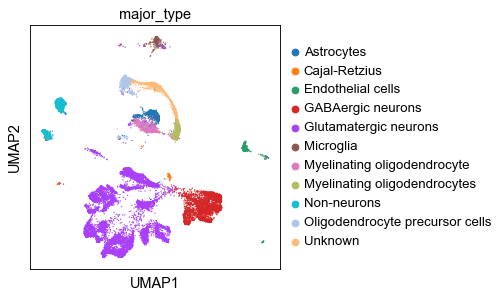

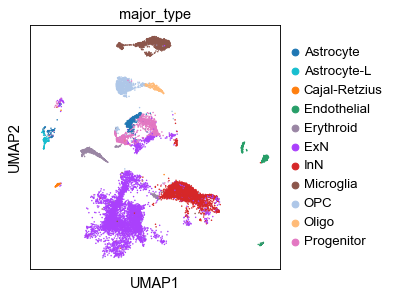

In [191]:
sc.pl.umap(adt1, color='major_type', save=f'-dog-major_type.pdf')
sc.pl.umap(adt2, color='major_type', save=f'-human-major_type.pdf')

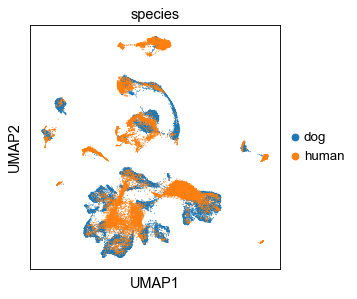

In [192]:
sc.pl.umap(adt, color='species', save='-harmony-species.pdf')

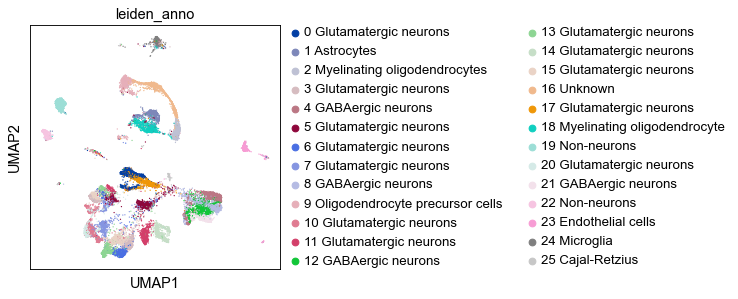

In [193]:
sc.pl.umap(adt1, color='leiden_anno', save=f'-dog-cluster.pdf')


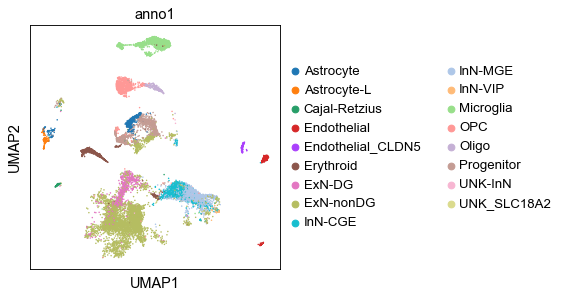

In [194]:
sc.pl.umap(adt2, color='anno1', save=f'-human-cluster.pdf')
